# Imports

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

warnings.filterwarnings("ignore")


# Config & Reproducibility

In [2]:
SEED = 42
BASE_PATH = "/kaggle/input/csiro-biomass"
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4  # ✅ Added this
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Load & Pivot Dataset

In [3]:
df = pd.read_csv(os.path.join(BASE_PATH, "train.csv"))
df = df.pivot_table(index="image_path", columns="target_name", values="target").reset_index()
df.fillna(0, inplace=True)

TARGET_COLUMNS = ['Dry_Green_g','Dry_Dead_g','Dry_Clover_g','GDM_g','Dry_Total_g']
print("Dataset shape:", df.shape)


Dataset shape: (357, 6)


# Train/Validation Split & Scaling

In [4]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=SEED, shuffle=True)
scaler = StandardScaler()
scaler.fit(train_df[TARGET_COLUMNS].values)


StandardScaler()

# Dataset Class & DataLoaders

In [5]:
class BiomassDataset(Dataset):
    def __init__(self, df, image_dir, transform=None, scaler=None):
        self.df = df.copy()
        self.df["image_path"] = self.df["image_path"].apply(os.path.basename)
        self.samples = list(self.df.itertuples(index=False))
        self.image_dir = image_dir
        self.transform = transform
        self.scaler = scaler

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        row = self.samples[idx]
        image = Image.open(os.path.join(self.image_dir, row.image_path)).convert("RGB")
        if self.transform:
            image = self.transform(image)
        target = np.array([getattr(row, t) for t in TARGET_COLUMNS], dtype=np.float32)
        if self.scaler:
            target = self.scaler.transform(target.reshape(1,-1))[0]
        return image, torch.tensor(target)

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_dataset = BiomassDataset(train_df, os.path.join(BASE_PATH,"train"), transform, scaler)
val_dataset = BiomassDataset(val_df, os.path.join(BASE_PATH,"train"), transform, scaler)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


# Weighted Loss & Metric

In [6]:
TARGET_WEIGHTS = torch.tensor([0.1,0.1,0.1,0.2,0.5], device=DEVICE)

class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.register_buffer("weights", weights)
    def forward(self, preds, targets):
        return ((preds-targets)**2 * self.weights).mean()

criterion = WeightedMSELoss(TARGET_WEIGHTS)

def weighted_r2_score(y_true, y_pred, weights):
    mean_y = y_true.mean(0, keepdim=True)
    ss_res = ((y_true - y_pred)**2).sum(0)
    ss_tot = ((y_true - mean_y)**2).sum(0)
    return (1 - (weights*ss_res).sum() / ((weights*ss_tot).sum()+1e-8)).item()


# Flexible CNN Model for Experimenting with Blocks

In [7]:
class FlexibleCNN(nn.Module):
    def __init__(self, num_blocks=3, base_channels=32, num_outputs=5):
        super().__init__()
        layers = []
        in_channels = 3
        out_channels = base_channels
        for i in range(num_blocks):
            layers.append(nn.Conv2d(in_channels, out_channels, 3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.MaxPool2d(2))
            in_channels = out_channels
            out_channels *= 2
        layers.append(nn.AdaptiveAvgPool2d(1))
        self.features = nn.Sequential(*layers)
        self.regressor = nn.Linear(in_channels, num_outputs)
    def forward(self, x):
        x = self.features(x)
        return self.regressor(x.flatten(1))


# Epoch Function

In [8]:
def run_epoch(model, loader, optimizer=None):
    training = optimizer is not None
    model.train() if training else model.eval()
    total_loss, total_r2, n = 0.0, 0.0, 0
    with torch.set_grad_enabled(training):
        for images, targets in loader:
            images, targets = images.to(DEVICE), targets.to(DEVICE)
            preds = model(images)
            loss = criterion(preds, targets)
            if training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            b = images.size(0)
            total_loss += loss.item()*b
            total_r2 += weighted_r2_score(targets, preds, TARGET_WEIGHTS)*b
            n += b
    return total_loss/n, total_r2/n


# Training & Plotting for Multiple Block Configurations

In [9]:
block_options = [2, 3, 4, 5]
results = {}

for num_blocks in block_options:
    print(f"\nTraining CNN with {num_blocks} blocks...")
    
    model = FlexibleCNN(
        num_blocks=num_blocks,
        base_channels=32,
        num_outputs=len(TARGET_COLUMNS)
    ).to(DEVICE)

    optimizer = optim.Adam(
        model.parameters(),
        lr=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY
    )

    train_losses, val_losses = [], []
    train_r2s, val_r2s = [], []

    for epoch in range(NUM_EPOCHS):
        tr_l, tr_r2 = run_epoch(model, train_loader, optimizer)
        va_l, va_r2 = run_epoch(model, val_loader)

        train_losses.append(tr_l)
        val_losses.append(va_l)
        train_r2s.append(tr_r2)
        val_r2s.append(va_r2)

        print(
            f"Epoch {epoch+1} | "
            f"Train Loss: {tr_l:.4f}, Train R²: {tr_r2:.4f} | "
            f"Val Loss: {va_l:.4f}, Val R²: {va_r2:.4f}"
        )

    results[num_blocks] = {
        "avg_train_loss": np.mean(train_losses),
        "avg_val_loss": np.mean(val_losses),
        "avg_train_r2": np.mean(train_r2s),
        "avg_val_r2": np.mean(val_r2s),
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_r2s": train_r2s,
        "val_r2s": val_r2s
    }




Training CNN with 2 blocks...
Epoch 1 | Train Loss: 0.1805, Train R²: 0.0260 | Val Loss: 0.1372, Val R²: -0.0138
Epoch 2 | Train Loss: 0.1622, Train R²: 0.1278 | Val Loss: 0.1375, Val R²: -0.0699
Epoch 3 | Train Loss: 0.1563, Train R²: 0.1682 | Val Loss: 0.1335, Val R²: -0.0231
Epoch 4 | Train Loss: 0.1572, Train R²: 0.1252 | Val Loss: 0.1287, Val R²: 0.0322
Epoch 5 | Train Loss: 0.1547, Train R²: 0.1783 | Val Loss: 0.1150, Val R²: 0.1507
Epoch 6 | Train Loss: 0.1531, Train R²: 0.1753 | Val Loss: 0.1222, Val R²: 0.0597
Epoch 7 | Train Loss: 0.1527, Train R²: 0.1818 | Val Loss: 0.1164, Val R²: 0.1266
Epoch 8 | Train Loss: 0.1501, Train R²: 0.1815 | Val Loss: 0.1453, Val R²: -0.1476
Epoch 9 | Train Loss: 0.1564, Train R²: 0.1456 | Val Loss: 0.1204, Val R²: 0.0788
Epoch 10 | Train Loss: 0.1509, Train R²: 0.1843 | Val Loss: 0.1162, Val R²: 0.1260
Epoch 11 | Train Loss: 0.1504, Train R²: 0.1838 | Val Loss: 0.1137, Val R²: 0.1464
Epoch 12 | Train Loss: 0.1447, Train R²: 0.1619 | Val Loss: 0

In [10]:
summary_blocks = pd.DataFrame.from_dict(results, orient="index")
summary_blocks.index.name = "Num_Blocks"
summary_blocks.reset_index(inplace=True)
summary_blocks


,Num_Blocks,avg_train_loss,avg_val_loss,avg_train_r2,avg_val_r2,train_losses,val_losses,train_r2s,val_r2s
0,2,0.151590,0.122704,0.171976,0.066071,"[0.18048036344218674, 0.16215475808110152, 0.1...","[0.13716513332393435, 0.13750191695160335, 0.1...","[0.026010393259818094, 0.12778112595541435, 0....","[-0.013787799411349826, -0.06988938649495442, ..."
1,3,0.146894,0.120324,0.192086,0.060947,"[0.19244544411960401, 0.1670037924197682, 0.15...","[0.12960321373409694, 0.13949323693911234, 0.1...","[-0.08948538387030885, 0.08673575802853233, 0....","[0.024859944979349773, -0.10245082113477919, 0..."
2,4,0.139775,0.146794,0.229320,-0.155584,"[0.22871638494625426, 0.16630231210014276, 0.1...","[0.14583172731929356, 0.27624425292015076, 0.1...","[-0.41539807863402783, 0.08554171930279648, 0....","[-0.0811692476272583, -1.300331751505534, -0.2..."
3,5,0.147634,0.143968,0.125531,-0.064501,"[0.38782147584777127, 0.16790938325095595, 0.1...","[0.1536963176396158, 0.1412452773915397, 0.135...","[-1.8450714594439457, 0.10485507396229526, 0.1...","[-0.14515462186601427, -0.09233992629581028, -..."


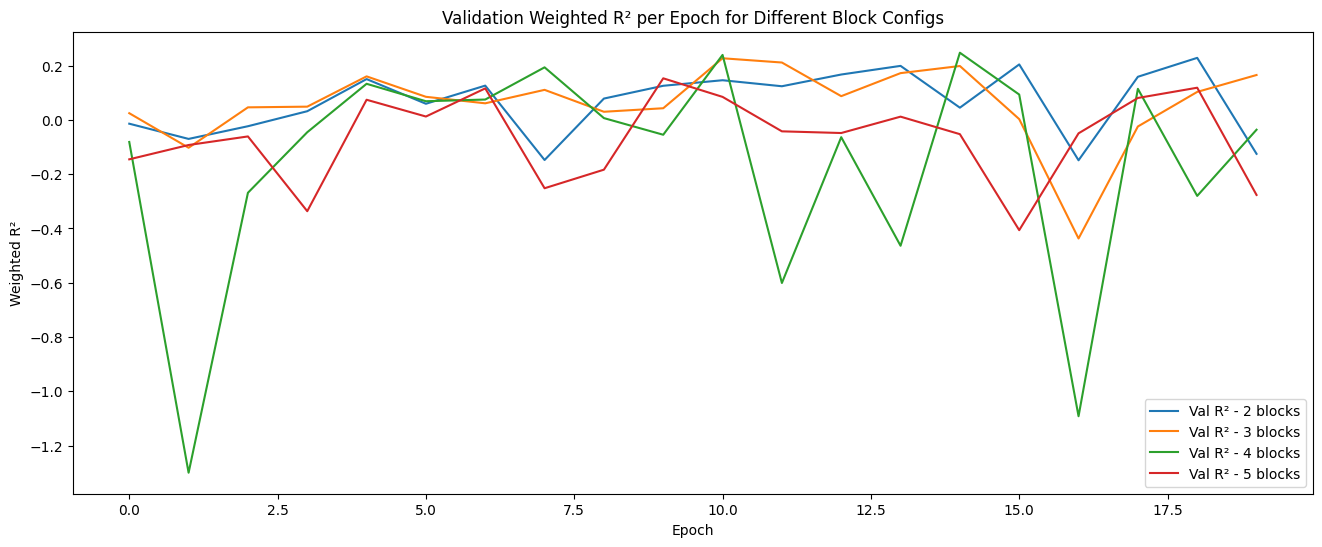

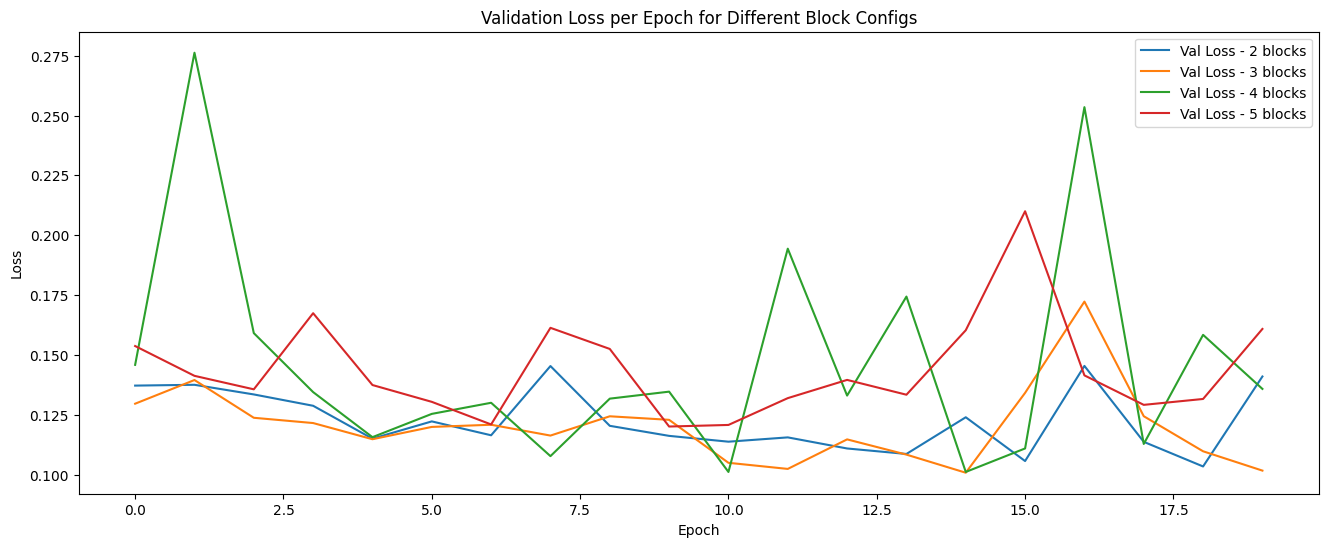

In [11]:
# ----------------------------
# Plot curves for all block options
# ----------------------------
plt.figure(figsize=(16,6))
for num_blocks in block_options:
    plt.plot(results[num_blocks]["val_r2s"], label=f"Val R² - {num_blocks} blocks")
plt.title("Validation Weighted R² per Epoch for Different Block Configs")
plt.xlabel("Epoch")
plt.ylabel("Weighted R²")
plt.legend()
plt.show()

plt.figure(figsize=(16,6))
for num_blocks in block_options:
    plt.plot(results[num_blocks]["val_losses"], label=f"Val Loss - {num_blocks} blocks")
plt.title("Validation Loss per Epoch for Different Block Configs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
